**Blok 1: Import Library**

In [1]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time
import copy
from collections import Counter
from PIL import Image

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models, datasets
from torchvision.transforms import v2

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


**Blok 2: Cek GPU dan Setup Device**

In [2]:
# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

if torch.cuda.is_available():
  current_device = torch.cuda.current_device()
  gpu_properties = torch.cuda.get_device_properties(current_device)
  print(f"GPU Name: {gpu_properties.name}")
  print(f"GPU Memory: {gpu_properties.total_memory / 1024**3:.2f} GB")
  print(f"GPU Compute Capability: {gpu_properties.major}.{gpu_properties.minor}")
else:
  print("No GPU available, using CPU")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

PyTorch version: 2.9.0+cu130
CUDA available: True
CUDA version: 13.0
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU
GPU Memory: 8.00 GB
GPU Compute Capability: 8.9

Using device: cuda


**Blok 3: Setup Path dan Parameters**

In [3]:
# Define dataset paths
train_dir = 'dataset/train'
test_dir = 'dataset/test'

# Check if directories exist
print("Checking dataset structure...")
if os.path.exists(train_dir) and os.path.exists(test_dir):
  train_classes = os.listdir(train_dir)
  test_classes = os.listdir(test_dir)
  print(f"Train classes: {train_classes}")
  print(f"Test classes: {test_classes}")
    
  # Count number of images per class
  print("\nNumber of images per class in train set:")
  for class_name in train_classes:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
      num_images = len(os.listdir(class_path))
      print(f"  {class_name}: {num_images} images")

  print("\nNumber of images per class in test set:")
  for class_name in test_classes:
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
      num_images = len(os.listdir(class_path))
      print(f"  {class_name}: {num_images} images")
else:
  print(f"Error: Dataset directories not found!")
  print(f"Train directory: {train_dir}")
  print(f"Test directory: {test_dir}")

# Training parameters
batch_size = 64
num_epochs = 50
num_classes = 7

Checking dataset structure...
Train classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Test classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Number of images per class in train set:
  angry: 3995 images
  disgust: 436 images
  fear: 4097 images
  happy: 7215 images
  neutral: 4965 images
  sad: 4830 images
  surprise: 3171 images

Number of images per class in test set:
  angry: 958 images
  disgust: 111 images
  fear: 1024 images
  happy: 1774 images
  neutral: 1233 images
  sad: 1247 images
  surprise: 831 images


**Blok 4: Exploratory Data Analysis (EDA)**

EXPLORATORY DATA ANALYSIS (EDA)

📁 DATASET STRUCTURE ANALYSIS
----------------------------------------
Train directory structure:
train/
  angry/
    Training_10118481.jpg
    Training_10120469.jpg
    Training_10131352.jpg
    ... and 3992 more files
  disgust/
    Training_10371709.jpg
    Training_10598340.jpg
    Training_1070239.jpg
    ... and 433 more files
  fear/
    Training_10018621.jpg
    Training_10031494.jpg
    Training_10110501.jpg
    ... and 4094 more files
  happy/
    Training_10019449.jpg
    Training_10046809.jpg
    Training_10066226.jpg
    ... and 7212 more files
  neutral/
    Training_10002154.jpg
    Training_10031781.jpg
    Training_10055498.jpg
    ... and 4962 more files
  sad/
    Training_10022789.jpg
    Training_10031481.jpg
    Training_10048646.jpg
    ... and 4827 more files
  surprise/
    Training_10013223.jpg
    Training_1002457.jpg
    Training_10028230.jpg
    ... and 3168 more files

Test directory structure:
test/
  angry/
    PrivateTest

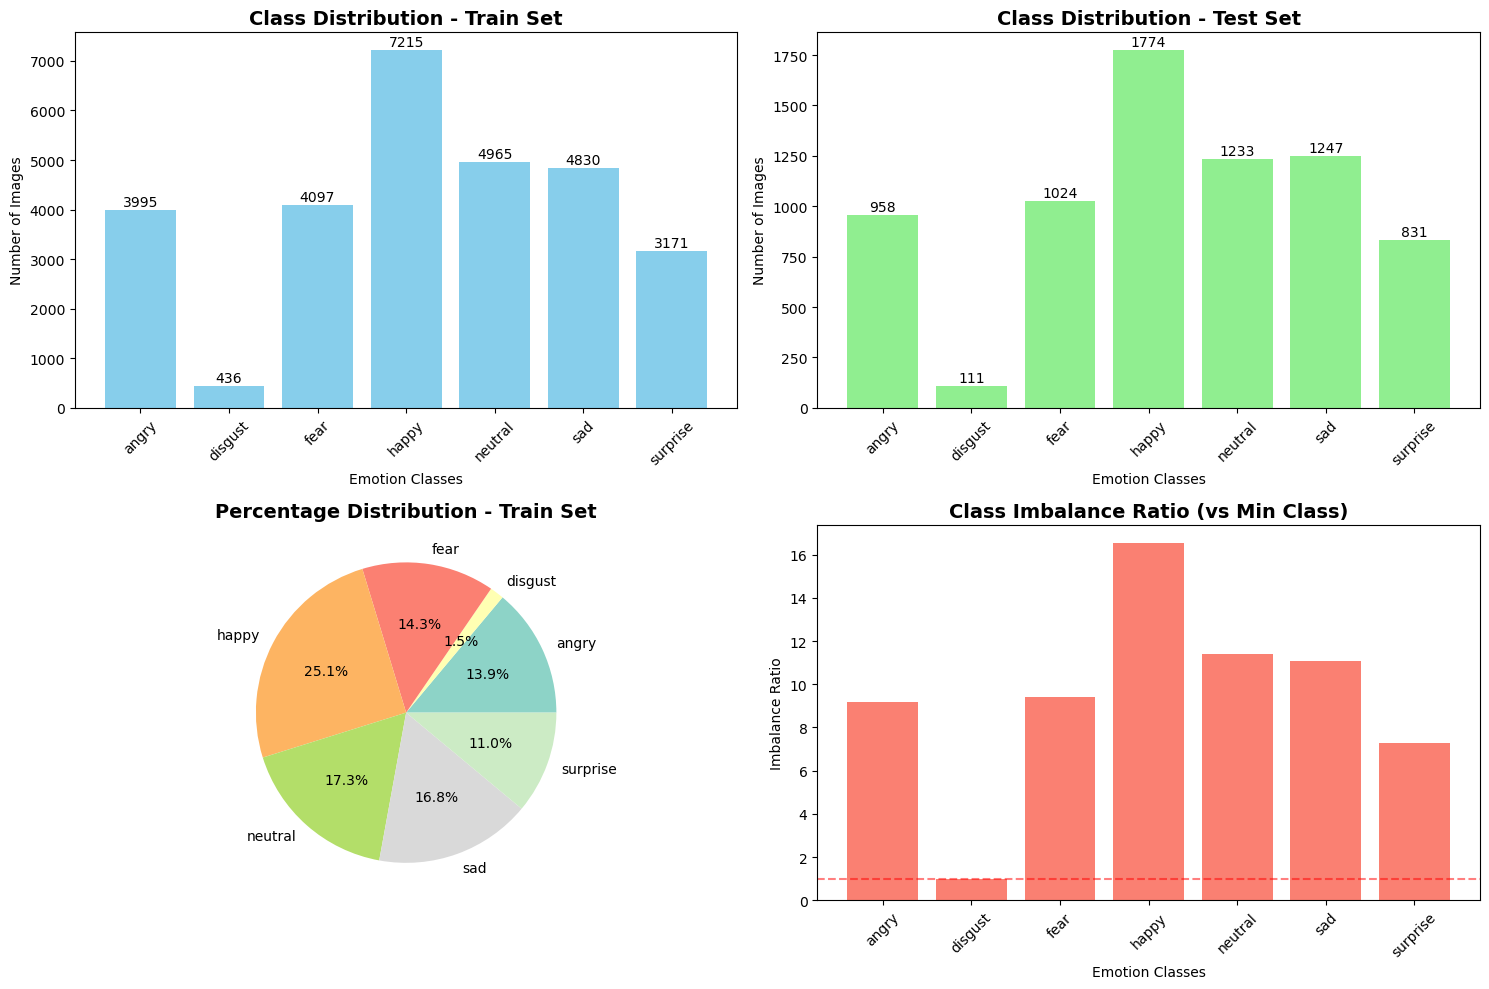


📈 DATASET STATISTICS SUMMARY
----------------------------------------
Total Training Images: 28,709
Total Test Images: 7,178
Total Images: 35,887

Per-class Statistics:

  ANGRY:
    Train:   3995 images ( 13.9%)
    Test:     958 images ( 13.3%)
    Total:   4953 images

  DISGUST:
    Train:    436 images (  1.5%)
    Test:     111 images (  1.5%)
    Total:    547 images

  FEAR:
    Train:   4097 images ( 14.3%)
    Test:    1024 images ( 14.3%)
    Total:   5121 images

  HAPPY:
    Train:   7215 images ( 25.1%)
    Test:    1774 images ( 24.7%)
    Total:   8989 images

  NEUTRAL:
    Train:   4965 images ( 17.3%)
    Test:    1233 images ( 17.2%)
    Total:   6198 images

  SAD:
    Train:   4830 images ( 16.8%)
    Test:    1247 images ( 17.4%)
    Total:   6077 images

  SURPRISE:
    Train:   3171 images ( 11.0%)
    Test:     831 images ( 11.6%)
    Total:   4002 images

🖼️ SAMPLE IMAGES VISUALIZATION
----------------------------------------


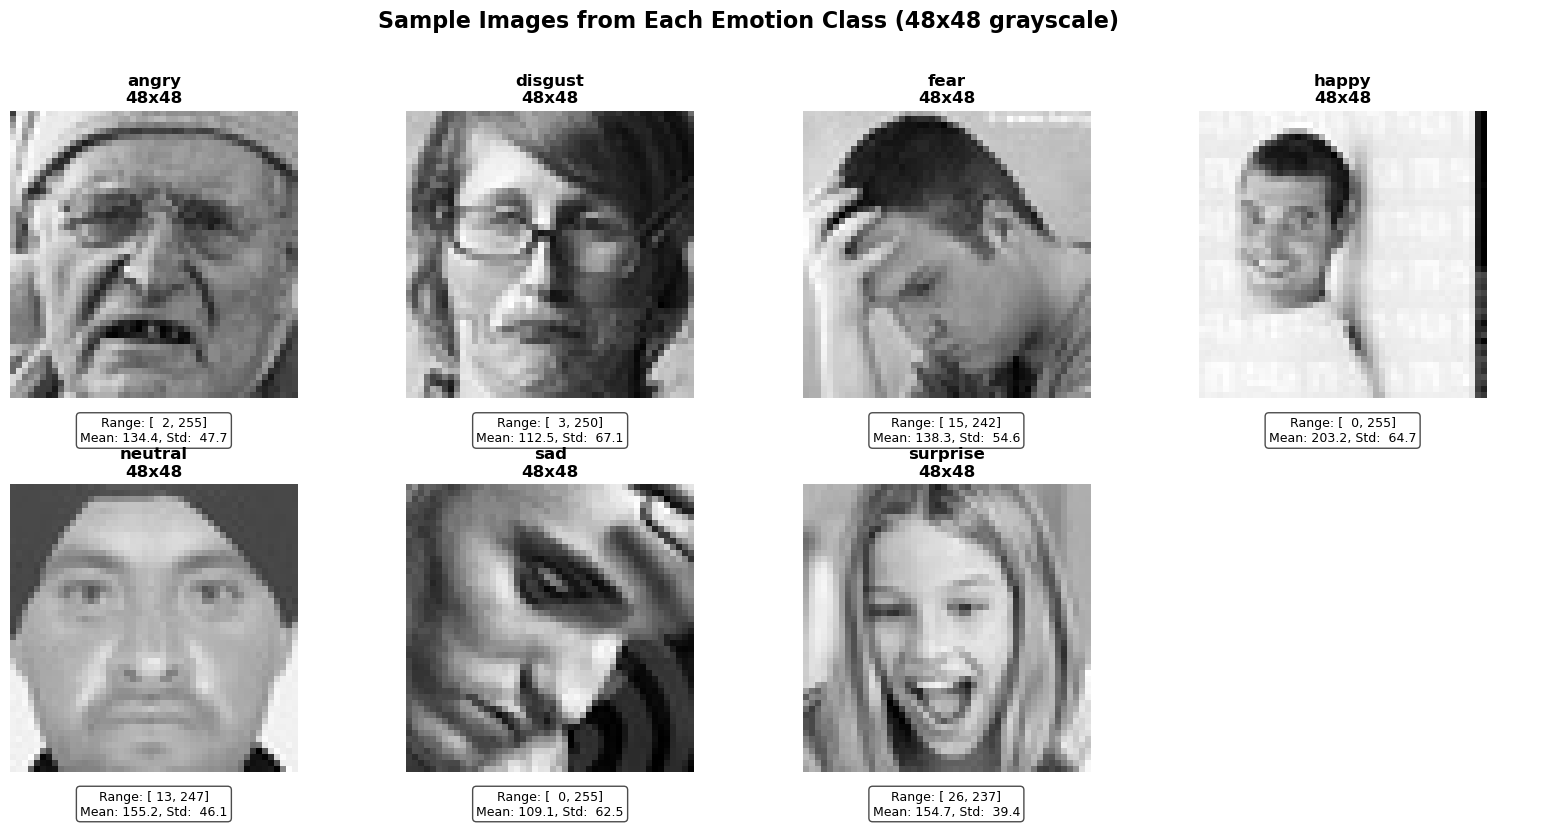


💡 EDA INSIGHTS & RECOMMENDATIONS
----------------------------------------
1. DATA DISTRIBUTION:
   • Dataset memiliki 7 kelas emosi
   • Total 35,887 gambar (Train: 28,709, Test: 7,178)
   • Rasio train/test: 4.00:1

2. CLASS IMBALANCE:
   • Ketidakseimbangan maksimum: 16.5x
   • Rekomendasi: Gunakan class weighting atau oversampling

3. IMAGE CHARACTERISTICS:
   • Semua gambar: 48x48 piksel, grayscale
   • Perlu: Konversi ke RGB untuk ResNet, Resize ke 224x224

4. DATA AUGMENTATION NEEDS:
   • Wajah memiliki variasi pose dan ekspresi
   • Rekomendasi: Horizontal flip, rotation, color jitter

✅ EDA completed successfully!


In [4]:
# Blok 4: Exploratory Data Analysis (EDA)
print("=" * 60)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("=" * 60)

# 1. Analisis Struktur Dataset
print("\n📁 DATASET STRUCTURE ANALYSIS")
print("-" * 40)

# Check folder structure
def analyze_folder_structure(base_path):
    structure = {}
    for root, dirs, files in os.walk(base_path):
        level = root.replace(base_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files[:3]:  # Show only 3 files per folder
            print(f'{subindent}{file}')
        if len(files) > 3:
            print(f'{subindent}... and {len(files)-3} more files')
    
    return structure

print("Train directory structure:")
analyze_folder_structure(train_dir)

print("\nTest directory structure:")
analyze_folder_structure(test_dir)

# 2. Analisis Distribusi Kelas
print("\n📊 CLASS DISTRIBUTION ANALYSIS")
print("-" * 40)

# Get class names from folder structure
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
print(f"Found {len(class_names)} emotion classes:")
for i, cls in enumerate(class_names):
    print(f"  {i}. {cls}")

# Count images per class in train and test sets
train_counts = {}
test_counts = {}

for cls in class_names:
    train_cls_path = os.path.join(train_dir, cls)
    test_cls_path = os.path.join(test_dir, cls)
    
    if os.path.exists(train_cls_path):
        train_counts[cls] = len([f for f in os.listdir(train_cls_path) 
                                if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    if os.path.exists(test_cls_path):
        test_counts[cls] = len([f for f in os.listdir(test_cls_path) 
                               if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Train set bar chart
train_values = [train_counts.get(cls, 0) for cls in class_names]
bars1 = axes[0, 0].bar(class_names, train_values, color='skyblue')
axes[0, 0].set_title('Class Distribution - Train Set', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Emotion Classes')
axes[0, 0].set_ylabel('Number of Images')
axes[0, 0].tick_params(axis='x', rotation=45)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 20,
                   f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Test set bar chart
test_values = [test_counts.get(cls, 0) for cls in class_names]
bars2 = axes[0, 1].bar(class_names, test_values, color='lightgreen')
axes[0, 1].set_title('Class Distribution - Test Set', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Emotion Classes')
axes[0, 1].set_ylabel('Number of Images')
axes[0, 1].tick_params(axis='x', rotation=45)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 5,
                   f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Train set pie chart
train_total = sum(train_values)
train_percentages = [v/train_total*100 for v in train_values]
axes[1, 0].pie(train_percentages, labels=class_names, autopct='%1.1f%%', 
               colors=plt.cm.Set3(np.arange(len(class_names))/len(class_names)))
axes[1, 0].set_title('Percentage Distribution - Train Set', fontsize=14, fontweight='bold')

# Class imbalance ratio
imbalance_ratios = {}
for cls in class_names:
    if train_counts[cls] > 0:
        imbalance_ratios[cls] = train_counts[cls] / min(train_counts.values())

axes[1, 1].bar(class_names, [imbalance_ratios.get(cls, 0) for cls in class_names], 
               color='salmon')
axes[1, 1].set_title('Class Imbalance Ratio (vs Min Class)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Emotion Classes')
axes[1, 1].set_ylabel('Imbalance Ratio')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].axhline(y=1, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 3. Analisis Statistik Dataset
print("\n📈 DATASET STATISTICS SUMMARY")
print("-" * 40)

total_train = sum(train_counts.values())
total_test = sum(test_counts.values())
total_all = total_train + total_test

print(f"Total Training Images: {total_train:,}")
print(f"Total Test Images: {total_test:,}")
print(f"Total Images: {total_all:,}")

print("\nPer-class Statistics:")
for cls in class_names:
    train_count = train_counts.get(cls, 0)
    test_count = test_counts.get(cls, 0)
    train_percent = train_count/total_train*100 if total_train > 0 else 0
    test_percent = test_count/total_test*100 if total_test > 0 else 0
    
    print(f"\n  {cls.upper()}:")
    print(f"    Train: {train_count:6d} images ({train_percent:5.1f}%)")
    print(f"    Test:  {test_count:6d} images ({test_percent:5.1f}%)")
    print(f"    Total: {train_count + test_count:6d} images")

# 4. Visualisasi Sample Images
print("\n🖼️ SAMPLE IMAGES VISUALIZATION")
print("-" * 40)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, cls in enumerate(class_names[:7]):  # Show 7 classes
    cls_path = os.path.join(train_dir, cls)
    if os.path.exists(cls_path):
        # Get random image
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            img_name = np.random.choice(images)
            img_path = os.path.join(cls_path, img_name)
            
            # Load image
            img = Image.open(img_path)
            
            # Display
            axes[idx].imshow(img, cmap='gray')
            axes[idx].set_title(f'{cls}\n{img.size[0]}x{img.size[1]}', 
                               fontsize=12, fontweight='bold')
            axes[idx].axis('off')
            
            # Add image statistics
            img_array = np.array(img)
            axes[idx].text(0.5, -0.15, 
                          f'Range: [{img_array.min():3.0f}, {img_array.max():3.0f}]\nMean: {img_array.mean():5.1f}, Std: {img_array.std():5.1f}',
                          transform=axes[idx].transAxes, ha='center', fontsize=9,
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        else:
            axes[idx].axis('off')
            axes[idx].set_title(f'{cls}\n(No images)', fontsize=12)
    else:
        axes[idx].axis('off')
        axes[idx].set_title(f'{cls}\n(Not found)', fontsize=12)

# Hide unused subplot
axes[7].axis('off')

plt.suptitle('Sample Images from Each Emotion Class (48x48 grayscale)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 5. Insights dari EDA
print("\n💡 EDA INSIGHTS & RECOMMENDATIONS")
print("-" * 40)

print("1. DATA DISTRIBUTION:")
print(f"   • Dataset memiliki {len(class_names)} kelas emosi")
print(f"   • Total {total_all:,} gambar (Train: {total_train:,}, Test: {total_test:,})")
print(f"   • Rasio train/test: {total_train/total_test:.2f}:1")

print("\n2. CLASS IMBALANCE:")
max_imbalance = max(imbalance_ratios.values()) if imbalance_ratios else 1
print(f"   • Ketidakseimbangan maksimum: {max_imbalance:.1f}x")
print(f"   • Rekomendasi: Gunakan class weighting atau oversampling")

print("\n3. IMAGE CHARACTERISTICS:")
print("   • Semua gambar: 48x48 piksel, grayscale")
print("   • Perlu: Konversi ke RGB untuk ResNet, Resize ke 224x224")

print("\n4. DATA AUGMENTATION NEEDS:")
print("   • Wajah memiliki variasi pose dan ekspresi")
print("   • Rekomendasi: Horizontal flip, rotation, color jitter")

print("\n✅ EDA completed successfully!")

**Blok 4: Data Transforms dan Augmentation**

In [4]:
# Enhanced data transformations with heavy augmentation
train_transform = v2.Compose([
  v2.Resize((224, 224)),  # Resize for ResNet
  v2.RandomHorizontalFlip(p=0.5),
  v2.RandomRotation(degrees=15),
  v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
  v2.ColorJitter(brightness=0.2, contrast=0.2),
  v2.RandomGrayscale(p=0.1),
  v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

val_transform = v2.Compose([
  v2.Resize((224, 224)),
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = val_transform  # Same as validation transform

print("Data transforms defined successfully!")

Data transforms defined successfully!


**Blok 5: Load Dataset dengan ImageFolder**

In [5]:
# Load datasets using ImageFolder
print("Loading datasets...")

try:
  train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
  test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
    
  # Get class names
  class_names = train_dataset.classes
  print(f"Class names: {class_names}")
  print(f"Number of classes: {len(class_names)}")

  print(f"Training samples: {len(train_dataset)}")
  print(f"Test samples: {len(test_dataset)}")
    
  # Split train into train and validation (90% train, 10% validation)
  train_size = int(0.9 * len(train_dataset))
  val_size = len(train_dataset) - train_size

  train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
  )
    
  # Apply validation transform to validation set
  val_dataset.dataset = copy.deepcopy(val_dataset.dataset)
  val_dataset.dataset.transform = val_transform

  print(f"After split - Training samples: {len(train_dataset)}")
  print(f"After split - Validation samples: {len(val_dataset)}")
  print(f"After split - Test samples: {len(test_dataset)}")

except Exception as e:
  print(f"Error loading datasets: {e}")
  # Create dummy datasets for demonstration if real datasets not available
  from torchvision.datasets import FakeData

  train_dataset = FakeData(size=28000, image_size=(3, 48, 48), num_classes=7, 
                        transform=train_transform)
  val_dataset = FakeData(size=3500, image_size=(3, 48, 48), num_classes=7, 
                        transform=val_transform)
  test_dataset = FakeData(size=3500, image_size=(3, 48, 48), num_classes=7, 
                        transform=test_transform)
  class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

Loading datasets...
Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of classes: 7
Training samples: 28709
Test samples: 7178
After split - Training samples: 25838
After split - Validation samples: 2871
After split - Test samples: 7178
